<a href="https://colab.research.google.com/github/chanho-275/WOWS/blob/main/back_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install --upgrade numpy pykrx

  Using cached numpy-2.4.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)


In [26]:
# 삼성전자 10년치 주가 데이터

from pykrx import stock
import numpy as np
import pandas as pd
import datetime

# 1. 날짜 설정
end_date = datetime.datetime.now().strftime("%Y%m%d")
start_date = "20160101" # 넉넉하게 10년치

# 2. 삼성전자 OHLCV 데이터 (종가, 저가 모두 포함)
ticker = "005930"
df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)

# 3. 필요한 컬럼만 추출 및 한글명 변경 (실무 감성)
df = df[['종가', '저가']].copy()
df.columns = ['Close', 'Low']
df['Close_Avg3'] = df['Close'].rolling(window=3).mean()
print(f"데이터 확인 (최근 5일):\n{df.head()}")

데이터 확인 (최근 5일):
            Close    Low    Close_Avg3
날짜                                    
2016-01-04  24100  24100           NaN
2016-01-05  24160  23720           NaN
2016-01-06  23500  23360  23920.000000
2016-01-07  23260  23020  23640.000000
2016-01-08  23420  23260  23393.333333


In [27]:
# modified following 일자 구하기

# 2-1. 데이터프레임의 날짜들만 따로 뽑아서 'trading_days'라는 변수에 담기
trading_days = df.index

# 확인용: 잘 들어갔는지 상위 5개만 출력해봅시다.
print("--- 영업일 리스트 확인 ---")
print(trading_days[:5])
print(f"총 영업일 수: {len(trading_days)}일")

# 2-2. Modified Following 함수 (이건 아까 설명드린 로직 그대로입니다)
def get_modified_following(target_date, trading_days):
    # target_date 이후 가장 빠른 실제 영업일 찾기
    future_days = trading_days[trading_days >= target_date]

    if len(future_days) == 0:
        return trading_days[-1]  # 데이터 범위를 벗어나면 마지막 날 반환

    actual_date = future_days[0]

    # [Modified 규칙] 만약 다음 영업일로 넘겼더니 달(Month)이 바뀌었다면?
    if actual_date.month != target_date.month:
        # target_date 이전 가장 가까운 영업일로 후진(Back)
        past_days = trading_days[trading_days <= target_date]
        actual_date = past_days[-1]

    return actual_date

# [테스트] 2023년 12월 31일(일) -> 12월 28일(목)이 나오는지 확인
test_dt = pd.Timestamp("2023-12-31")
print(f"\n테스트 결과: {get_modified_following(test_dt, trading_days).date()}")

--- 영업일 리스트 확인 ---
DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08'],
              dtype='datetime64[ns]', name='날짜', freq=None)
총 영업일 수: 2474일

테스트 결과: 2023-12-28


In [28]:
# 모델 구축 및 특정일로 확인하

from dateutil.relativedelta import relativedelta

# --- [3단계: 상품 조건 설정] ---
REDEMPTION_STEPS = [6, 12, 18, 24, 30, 36]        # 평가 주기 (개월)
BARRIERS = [0.90, 0.85, 0.85, 0.80, 0.75, 0.70]   # 조기상환 배리어 (주임님 오더)
KI_BARRIER_RATIO = 0.50                           # 낙인 배리어 (50%)
ANNUAL_COUPON = 0.104                             # 연 수익률 (10.4%)
COUPON_PER_STEP = ANNUAL_COUPON / 2                # 6개월 수익률 (5.2%)

# --- [4단계: 단일 상품 시뮬레이션 함수] ---
def simulate_single_els(issuance_date, df):
    # 2단계에서 정의한 trading_days 사용
    trading_days = df.index

    # 1. 발행일 기준가 (3일 종가 평균)
    base_price = df.loc[issuance_date, 'Close_Avg3']

    # 데이터 부족(NaN) 시 패스
    if pd.isna(base_price): return None

    # 2. 36개월 뒤 만기 타겟 날짜
    maturity_target = issuance_date + relativedelta(months=36)
    if maturity_target > trading_days[-1]: return None

    # 3. 생애 주기 데이터 슬라이싱
    life_cycle = df.loc[issuance_date : maturity_target]

    # 4. [KI 체크] 장중 저가(Low)가 기준가의 50%를 한 번이라도 쳤는가?
    is_ki_event = (life_cycle['Low'] < (base_price * KI_BARRIER_RATIO)).any()

    # 5. [상환 체크] 6개월 단위 루프
    for i, m in enumerate(REDEMPTION_STEPS):
        theoretical_date = issuance_date + relativedelta(months=m)
        # 2단계에서 만든 보정기 함수 사용
        actual_eval_date = get_modified_following(theoretical_date, trading_days)

        # 만기일 범위를 넘지 않게 조정
        if actual_eval_date > life_cycle.index[-1]:
            actual_eval_date = life_cycle.index[-1]

        # 평가일 종가 (3일 평균)
        eval_price = df.loc[actual_eval_date, 'Close_Avg3']

        # 상환 배리어 돌파 확인
        if (eval_price / base_price) >= BARRIERS[i]:
            return {
                "발행일": issuance_date,
                "상환일": actual_eval_date,
                "구분": f"{i+1}차 상환" if m < 36 else "만기정상상환",
                "수익률": (i + 1) * COUPON_PER_STEP,
                "KI발생": is_ki_event
            }

    # 6. [모든 상환 실패 시 - 페이오프 전환]
    final_avg_price = df.loc[life_cycle.index[-1], 'Close_Avg3']
    final_perf = final_avg_price / base_price

    if not is_ki_event:
        # 노낙인 만기 상환 (더미 쿠폰 3년치 보장)
        return {"발행일": issuance_date, "상환일": life_cycle.index[-1], "구분": "만기(No-KI)", "수익률": 3 * ANNUAL_COUPON, "KI발생": False}
    else:
        # 낙인 발생 후 만기 상환 실패 (손실 전가)
        # 만기 주가가 100% 회복 못하면 하락분만큼 손실, 회복하면 쿠폰 지급
        res_return = (final_perf - 1.0) if final_perf < 1.0 else (3 * ANNUAL_COUPON)
        return {"발행일": issuance_date, "상환일": life_cycle.index[-1], "구분": "원금손실", "수익률": res_return, "KI발생": True}

# --- [테스트 실행] ---
# 2018년 초 아무 날짜나 골라서 테스트해봅니다.
test_date = pd.Timestamp("2018-01-05")
result = simulate_single_els(test_date, df)

print(f"--- {test_date.date()} 발행 건 시뮬레이션 결과 ---")
print(result)

--- 2018-01-05 발행 건 시뮬레이션 결과 ---
{'발행일': Timestamp('2018-01-05 00:00:00'), '상환일': Timestamp('2019-07-05 00:00:00'), '구분': '3차 상환', '수익률': 0.156, 'KI발생': True}


In [29]:
# 낙인 시점 확인하기

def simulate_single_els(issuance_date, df):
    trading_days = df.index

    # 1. 발행일 기준가 (3일 종가 평균)
    base_price = df.loc[issuance_date, 'Close_Avg3']
    if pd.isna(base_price): return None

    # 2. 36개월 뒤 만기 타겟
    maturity_target = issuance_date + relativedelta(months=36)
    if maturity_target > trading_days[-1]: return None

    # 3. 생애 주기 데이터 슬라이싱
    life_cycle = df.loc[issuance_date : maturity_target]

    # --- [핵심] KI 상세 정보 미리 파악하기 ---
    ki_barrier = base_price * KI_BARRIER_RATIO
    # 배리어를 터치한 날들을 모두 찾음
    ki_events = life_cycle[life_cycle['Low'] < ki_barrier]

    is_ki_event = not ki_events.empty
    ki_date = ki_events.index[0] if is_ki_event else None  # 최초 낙인일
    ki_price = ki_events.iloc[0]['Low'] if is_ki_event else None # 최초 낙인일 저가
    # ------------------------------------------

    # 4. [조기/만기 상환 체크 루프]
    for i, m in enumerate(REDEMPTION_STEPS):
        theoretical_date = issuance_date + relativedelta(months=m)
        actual_eval_date = get_modified_following(theoretical_date, trading_days)

        if actual_eval_date > life_cycle.index[-1]:
            actual_eval_date = life_cycle.index[-1]

        eval_price = df.loc[actual_eval_date, 'Close_Avg3']

        # 상환 조건 충족 시
        if (eval_price / base_price) >= BARRIERS[i]:
            # 여기서 return하면 함수 종료! 하지만 위에서 구한 KI 정보를 상자에 담아 나감
            return {
                "발행일": issuance_date,
                "상환일": actual_eval_date,
                "구분": f"{i+1}차 상환" if m < 36 else "만기정상상환",
                "수익률": (i + 1) * COUPON_PER_STEP,
                "KI발생여부": is_ki_event,
                "KI발생일": ki_date,      # 추가됨!
                "KI시점저가": ki_price    # 추가됨!
            }

    # 5. [모든 상환 실패 시] - 위 루프에서 return 안 됐을 때만 실행
    final_avg_price = df.loc[life_cycle.index[-1], 'Close_Avg3']
    final_perf = final_avg_price / base_price

    if not is_ki_event:
        return {
            "발행일": issuance_date, "상환일": life_cycle.index[-1], "구분": "만기(No-KI)",
            "수익률": 3 * ANNUAL_COUPON, "KI발생여부": False, "KI발생일": None, "KI시점저가": None
        }
    else:
        res_return = (final_perf - 1.0) if final_perf < 1.0 else (3 * ANNUAL_COUPON)
        return {
            "발행일": issuance_date, "상환일": life_cycle.index[-1], "구분": "원금손실",
            "수익률": res_return, "KI발생여부": True, "KI발생일": ki_date, "KI시점저가": ki_price
        }

# --- [재테스트: 2018-01-05] ---
test_date = pd.Timestamp("2018-01-05")
result = simulate_single_els(test_date, df)

print(f"--- {test_date.date()} 발행 건 정밀 시뮬레이션 결과 ---")
import pprint
pprint.pprint(result)

--- 2018-01-05 발행 건 정밀 시뮬레이션 결과 ---
{'KI발생여부': True,
 'KI발생일': Timestamp('2018-04-30 00:00:00'),
 'KI시점저가': 0.0,
 '구분': '3차 상환',
 '발행일': Timestamp('2018-01-05 00:00:00'),
 '상환일': Timestamp('2019-07-05 00:00:00'),
 '수익률': 0.156}


In [30]:
# 결측치 확인하기

zero_days = df[df['Low'] <= 0]
print(f"가격이 0인 날짜 수: {len(zero_days)}")
if len(zero_days) > 0:
    print(zero_days.head())

가격이 0인 날짜 수: 3
            Close  Low    Close_Avg3
날짜                                  
2018-04-30  53000    0  52713.333333
2018-05-02  53000    0  53000.000000
2018-05-03  53000    0  53000.000000


In [31]:
# 결측치 확인하기 2

# 1. Name the date we want to inspect
# 'event_date' 혹은 'target_dt'처럼 명확하게 작명합니다.
audit_date = "2018-04-30"

# 2. Find the row index (location) of the audit date
row_idx = df.index.get_loc(audit_date)

# 3. Slice the data around the event (Event Window)
# Using -5 and +6 to see 5 days before and 5 days after (Total 11 days)
event_window_df = df.iloc[row_idx - 5 : row_idx + 6]

print(f"--- Data Inspection for [ {audit_date} ] ---")
# Check 'Close', 'Low', and our 'Close_Avg3'
print(event_window_df[['Close', 'Low', 'Close_Avg3']])

--- Data Inspection for [ 2018-04-30 ] ---
            Close    Low    Close_Avg3
날짜                                    
2018-04-23  51900  51000  52100.000000
2018-04-24  50460  50080  51326.666667
2018-04-25  50400  49220  50920.000000
2018-04-26  52140  50400  51000.000000
2018-04-27  53000  52440  51846.666667
2018-04-30  53000      0  52713.333333
2018-05-02  53000      0  53000.000000
2018-05-03  53000      0  53000.000000
2018-05-04  51900  51800  52633.333333
2018-05-08  52600  51900  52500.000000
2018-05-09  50900  50900  51800.000000


In [32]:
# 데이터 클렌징

# 1. 'Low'가 0인 행을 찾아서, 그 행의 'Low'값을 해당 행의 'Close'값으로 바꿉니다.
# .loc[조건, 열이름] 방식을 쓰면 아주 정확하게 그 칸만 바꿀 수 있습니다.
# 1. 원본 df를 복사해서 df2를 만듭니다. (Deep Copy)
df2 = df.copy()

# 2. df2에 대해서만 정밀 수술 집도 (Low가 0인 날만 Close로 치환)
df2.loc[df2['Low'] <= 0, 'Low'] = df2['Close']

# 3. df2 기준으로 3일 평균가 계산
df2['Close_Avg3'] = df2['Close'].rolling(window=3).mean()

# 4. 루프에 사용할 영업일 리스트도 df2 기준으로 재지정
trading_days_v2 = df2.index
# 3. [현장 검증] 4월 30일 데이터가 어떻게 변했는지 확인해봅시다.
audit_date = "2018-04-30"
print(f"--- {audit_date} Low 정밀 치환 결과 ---")
print(df2.loc["2018-04-27":"2018-05-04", ['Close', 'Low', 'Close_Avg3']])

--- 2018-04-30 Low 정밀 치환 결과 ---
            Close    Low    Close_Avg3
날짜                                    
2018-04-27  53000  52440  51846.666667
2018-04-30  53000  53000  52713.333333
2018-05-02  53000  53000  53000.000000
2018-05-03  53000  53000  53000.000000
2018-05-04  51900  51800  52633.333333


In [33]:
# 데이터 클렌징 후 재확인

test_date = pd.Timestamp("2018-01-05")

# df2를 넣어서 시뮬레이션 실행
re_test_result = simulate_single_els(test_date, df2)

print(f"--- [df2 기반] {test_date.date()} 발행 건 재검증 결과 ---")
import pprint
pprint.pprint(re_test_result)

--- [df2 기반] 2018-01-05 발행 건 재검증 결과 ---
{'KI발생여부': False,
 'KI발생일': None,
 'KI시점저가': None,
 '구분': '3차 상환',
 '발행일': Timestamp('2018-01-05 00:00:00'),
 '상환일': Timestamp('2019-07-05 00:00:00'),
 '수익률': 0.156}


In [34]:
# 시뮬레이션 시행

from tqdm.auto import tqdm

# 결과를 담을 리스트
all_results_v2 = []

print(f"총 {len(trading_days_v2)}개 영업일에 대해 df2 데이터를 사용하여 전수 조사를 시작합니다.")

for issue_dt in tqdm(trading_days_v2):
    # 주임님의 정제 데이터 df2를 전달합니다.
    res = simulate_single_els(issue_dt, df2)

    if res is not None:
        all_results_v2.append(res)

# 최종 결과 데이터프레임
res_df_v2 = pd.DataFrame(all_results_v2)

print(f"\n[완료] 총 {len(res_df_v2)}건의 시뮬레이션 결과가 확보되었습니다.")

총 2474개 영업일에 대해 df2 데이터를 사용하여 전수 조사를 시작합니다.


  0%|          | 0/2474 [00:00<?, ?it/s]


[완료] 총 1741건의 시뮬레이션 결과가 확보되었습니다.


In [35]:
# 시뮬레이션 결과 정리

# 1. 상환 결과 분포 (가장 중요!)
print("--- [상환 유형별 최종 성적표] ---")
print(res_df_v2['구분'].value_counts())

# 2. 수익률 통계
avg_ret = res_df_v2['수익률'].mean() * 100
print(f"\n평균 수익률: {avg_ret:.2f}%")

# 3. 원금 손실 사례 정밀 타격
loss_cases = res_df_v2[res_df_v2['구분'] == "원금손실"]
print(f"원금 손실 건수: {len(loss_cases)}건")

if len(loss_cases) > 0:
    print("\n[주의] 원금 손실이 발생한 발행 시점들:")
    print(loss_cases[['발행일', '상환일', '수익률']].head())

--- [상환 유형별 최종 성적표] ---
구분
1차 상환    1500
2차 상환     123
3차 상환      77
5차 상환      28
4차 상환      13
Name: count, dtype: int64

평균 수익률: 6.48%
원금 손실 건수: 0건


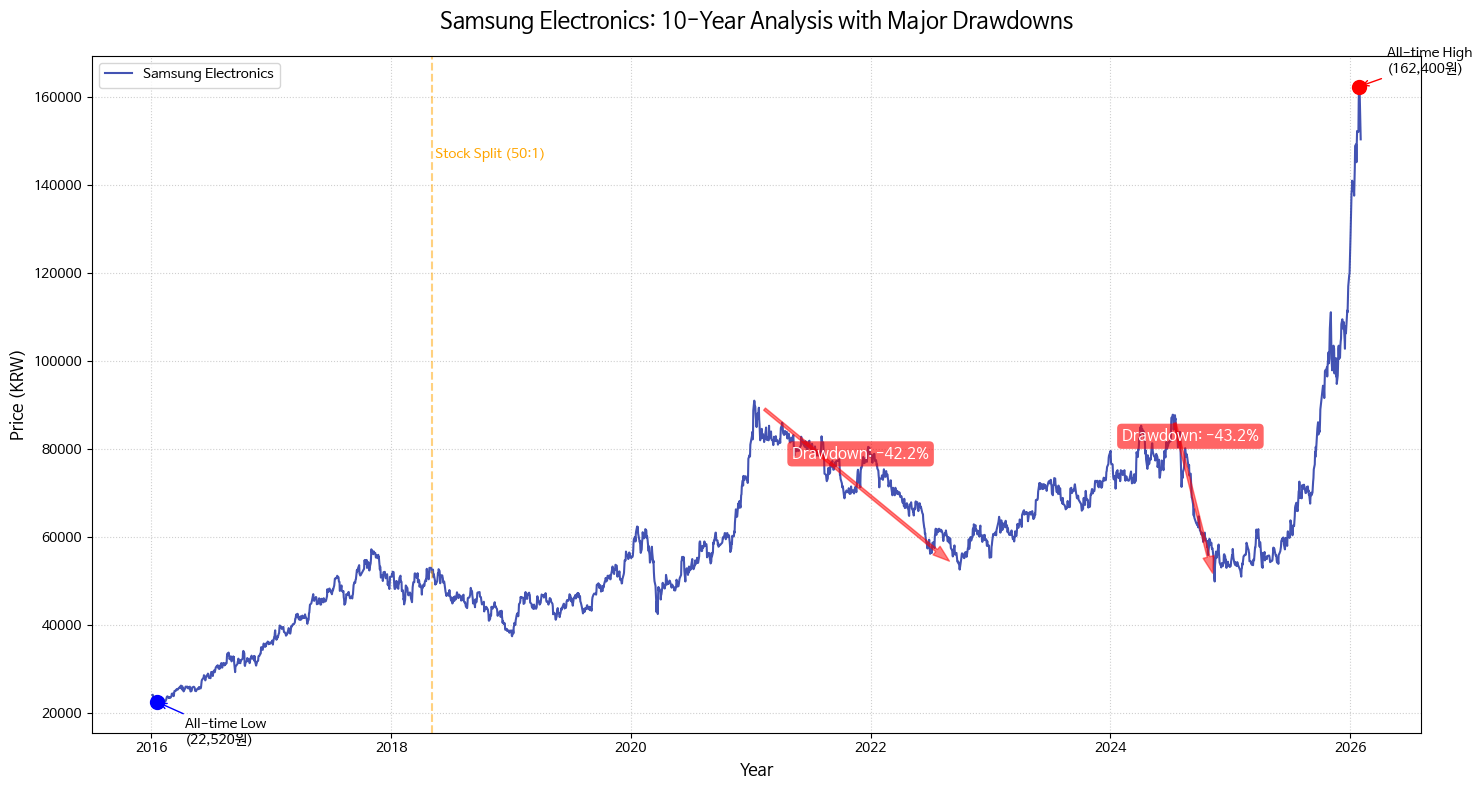

In [40]:
# 그래프 시각화 (EDA)

import matplotlib.pyplot as plt

# 1. 그래프 스타일 및 크기 설정
plt.figure(figsize=(15, 8))
plt.plot(df2.index, df2['Close'], label='Samsung Electronics', color='#1428a0', linewidth=1.5, alpha=0.8)

# 2. 최고점(All-time High) 표시
max_val = df2['Close'].max()
max_date = df2['Close'].idxmax()
plt.scatter(max_date, max_val, color='red', s=100, zorder=5)
plt.annotate(f'All-time High\n({max_val:,.0f}원)',
             xy=(max_date, max_val), xytext=(20, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# 3. 최저점(All-time Low) 표시
min_val = df2['Close'].min()
min_date = df2['Close'].idxmin()
plt.scatter(min_date, min_val, color='blue', s=100, zorder=5)
plt.annotate(f'All-time Low\n({min_val:,.0f}원)',
             xy=(min_date, min_val), xytext=(20, -30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='blue'))

# 4. 액면분할 이벤트 지점 표시 (2018-05-04)
split_date = pd.Timestamp("2018-05-04")
plt.axvline(split_date, color='orange', linestyle='--', alpha=0.5)
plt.text(split_date, max_val*0.9, ' Stock Split (50:1)', color='orange', fontweight='bold')

# ---------------------------------------------------------
# [추가] 5. 국지적 급락 구간 (Local Drawdown) 분석 및 표시
# ---------------------------------------------------------

def annotate_drawdown(start_dt, end_dt, text_pos):
    # 구간 내 최고점과 그 이후의 최저점 찾기
    sub_df = df2.loc[start_dt:end_dt]
    p_dt = sub_df['Close'].idxmax()
    p_val = sub_df.loc[p_dt, 'Close']

    post_peak_df = sub_df.loc[p_dt:]
    b_dt = post_peak_df['Close'].idxmin()
    b_val = post_peak_df.loc[b_dt, 'Close']

    drop_pct = (b_val - p_val) / p_val * 100

    # 하락 화살표 그리기
    plt.annotate('', xy=(b_dt, b_val), xytext=(p_dt, p_val),
                 arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, width=2, headwidth=8, alpha=0.5))

    # 하락률 텍스트 박스
    plt.text(text_pos[0], text_pos[1], f'Drawdown: {drop_pct:.1f}%',
             color='white', fontweight='bold', fontsize=11, ha='center',
             bbox=dict(facecolor='red', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3'))

# 첫 번째 급락 구간 (2021년 반도체 피크 아웃 우려기)
annotate_drawdown('2021-01-01', '2022-12-31', (pd.Timestamp('2021-12-01'), 78000))

# 두 번째 급락 구간 (2024년 최근 변동성 장세)
annotate_drawdown('2024-01-01', '2025-06-01', (pd.Timestamp('2024-09-01'), 82000))

# 6. 그래프 꾸미기 마무리
plt.title('Samsung Electronics: 10-Year Analysis with Major Drawdowns', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

현재 컬럼명: Index(['시가', '고가', '저가', '종가', '거래량', '등락률'], dtype='object')
카카오 10년 전수 조사 시작...


  0%|          | 0/2474 [00:00<?, ?it/s]

[완료] 총 1741건의 시뮬레이션 결과가 확보되었습니다.
--------------------------------------------------

--- [카카오 ELS 상환 성적표] ---
구분
1차 상환     1094
원금손실       236
2차 상환      201
3차 상환      111
만기정상상환      60
4차 상환       39
Name: count, dtype: int64

평균 수익률: -1.76%
낙인 발생 건수: 443건
최종 원금 손실 건수: 236건


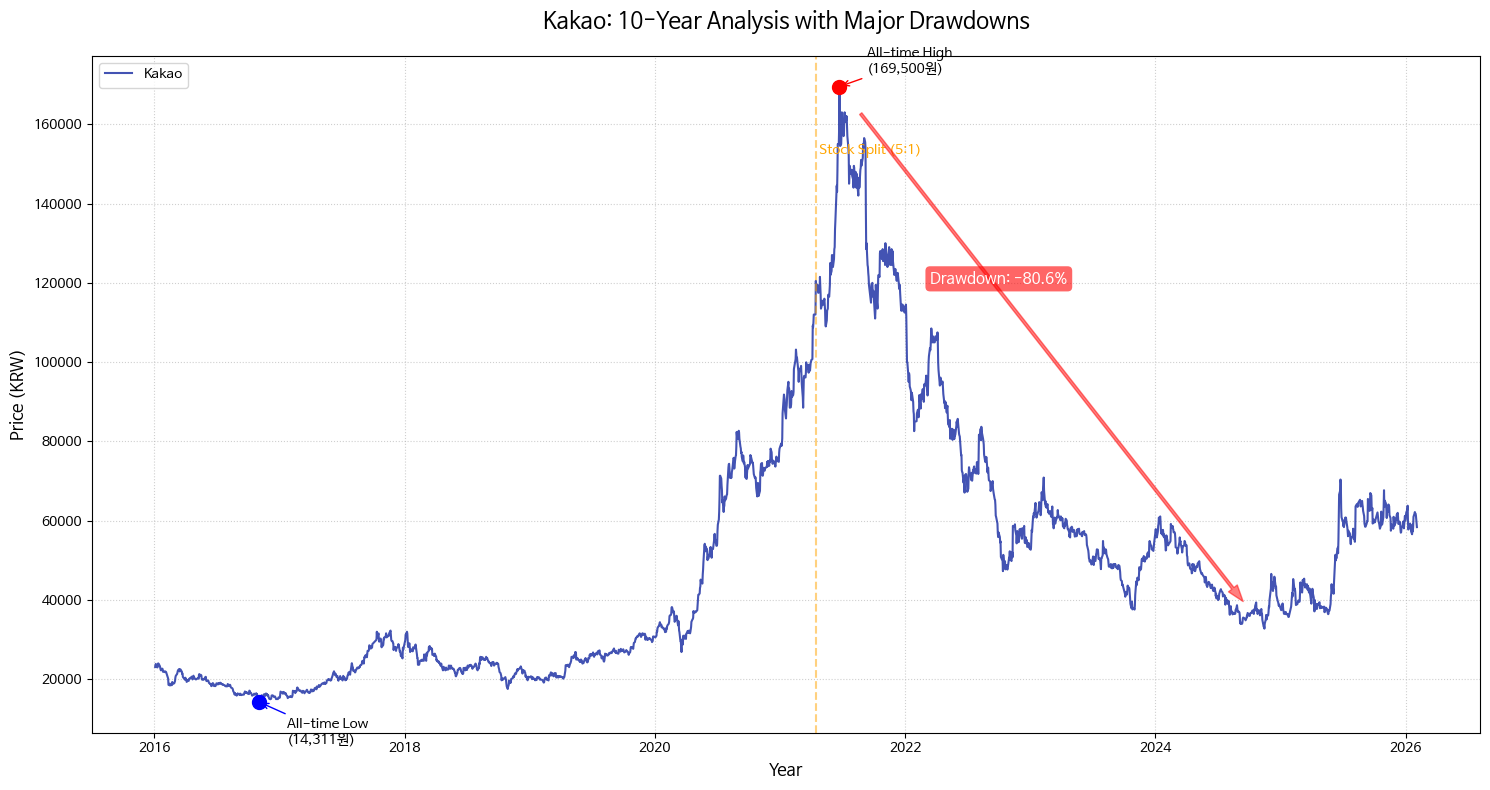

In [48]:
# 카카오 사례 분석

from datetime import datetime
ticker_kakao = "035720"
df_kakao = stock.get_market_ohlcv_by_date("20160101", datetime.now().strftime("%Y%m%d"), ticker_kakao)

# [체크!] 컬럼명이 한글인지 영어인지 출력해봅시다
print("현재 컬럼명:", df_kakao.columns)
# 1. 컬럼명 영문으로 변환 (주임님이 확인하신 순서대로 매핑)
df_kakao.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
# 2. 데이터 정제 (DF2 체제)
df2_kakao = df_kakao.copy()
df2_kakao.loc[df2_kakao['Low'] <= 0, 'Low'] = df2_kakao['Close']
df2_kakao['Close_Avg3'] = df2_kakao['Close'].rolling(window=3).mean()
trading_days_kakao = df2_kakao.index

# 3. 전수 조사 루프 실행
kakao_results = []
print("카카오 10년 전수 조사 시작...")

for issue_dt in tqdm(trading_days_kakao):
    # 기존에 정의한 simulate_single_els 함수를 그대로 사용 (df2_kakao 전달)
    res = simulate_single_els(issue_dt, df2_kakao)
    if res is not None:
        kakao_results.append(res)

res_df_kakao = pd.DataFrame(kakao_results)

print(f"[완료] 총 {len(res_df_kakao)}건의 시뮬레이션 결과가 확보되었습니다.")
print("-" * 50)

# 4. 결과 출력
print("\n--- [카카오 ELS 상환 성적표] ---")
print(res_df_kakao['구분'].value_counts())
print(f"\n평균 수익률: {res_df_kakao['수익률'].mean() * 100:.2f}%")
print(f"낙인 발생 건수: {res_df_kakao['KI발생여부'].sum()}건")
print(f"최종 원금 손실 건수: {len(res_df_kakao[res_df_kakao['구분'] == '원금손실'])}건")



# 1. 그래프 스타일 및 크기 설정 (삼성전자와 동일하게 화이트 톤)
plt.figure(figsize=(15, 8))
plt.plot(df2_kakao.index, df2_kakao['Close'], label='Kakao', color='#1428a0', linewidth=1.5, alpha=0.8)

# 2. 최고점(All-time High) 찾기 및 표시
max_val_k = df2_kakao['Close'].max()
max_date_k = df2_kakao['Close'].idxmax()
plt.scatter(max_date_k, max_val_k, color='red', s=100, zorder=5)
plt.annotate(f'All-time High\n({max_val_k:,.0f}원)',
             xy=(max_date_k, max_val_k), xytext=(20, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# 3. 최저점(All-time Low) 찾기 및 표시
min_val_k = df2_kakao['Close'].min()
min_date_k = df2_kakao['Close'].idxmin()
plt.scatter(min_date_k, min_val_k, color='blue', s=100, zorder=5)
plt.annotate(f'All-time Low\n({min_val_k:,.0f}원)',
             xy=(min_date_k, min_val_k), xytext=(20, -30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='blue'))

# 4. 카카오 액면분할 이벤트 지점 표시 (2021-04-15)
split_date_k = pd.Timestamp("2021-04-15")
plt.axvline(split_date_k, color='orange', linestyle='--', alpha=0.5)
plt.text(split_date_k, max_val_k*0.9, ' Stock Split (5:1)', color='orange', fontweight='bold')

# ---------------------------------------------------------
# 5. 국지적 급락 구간 (Local Drawdown) 분석 및 표시
# ---------------------------------------------------------
def annotate_drawdown_standard(start_dt, end_dt, text_pos):
    sub_df = df2_kakao.loc[start_dt:end_dt]
    if sub_df.empty: return
    p_dt = sub_df['Close'].idxmax()
    p_val = sub_df.loc[p_dt, 'Close']

    post_peak_df = sub_df.loc[p_dt:]
    b_dt = post_peak_df['Close'].idxmin()
    b_val = post_peak_df.loc[b_dt, 'Close']

    drop_pct = (b_val - p_val) / p_val * 100

    # 하락 화살표 (삼성전자와 동일한 빨간 화살표 스타일)
    plt.annotate('', xy=(b_dt, b_val), xytext=(p_dt, p_val),
                 arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05, width=2, headwidth=8, alpha=0.5))

    # 하락률 텍스트 박스
    plt.text(text_pos[0], text_pos[1], f'Drawdown: {drop_pct:.1f}%',
             color='white', fontweight='bold', fontsize=11, ha='center',
             bbox=dict(facecolor='red', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3'))

# 카카오의 주요 급락 구간 (2021년 고점 이후)
annotate_drawdown_standard('2021-01-01', '2024-12-31', (pd.Timestamp('2022-10-01'), 120000))

# 6. 그래프 꾸미기 마무리 (삼성전자와 일치)
plt.title('Kakao: 10-Year Analysis with Major Drawdowns', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [50]:
# 원금 손실 사례 분석

loss_df_kakao = res_df_kakao[res_df_kakao['구분'] == "원금손실"].copy()

# 2. 손실 건수 및 평균 손실률 계산
loss_count = len(loss_df_kakao)
avg_loss_return = loss_df_kakao['수익률'].mean() * 100
min_loss_return = loss_df_kakao['수익률'].min() * 100 # 가장 크게 깨진 사례

print(f"[분석 완료] 원금 손실 총 {loss_count}건에 대한 상세 통계")
print("-" * 50)
print(f"1. 손실 발생 건수: {loss_count}건")
print(f"2. 손실 건 평균 수익률: {avg_loss_return:.2f}% (원금의 약 {100+avg_loss_return:.1f}% 회수)")
print(f"3. 최악의 수익률 (Max Loss): {min_loss_return:.2f}%")
print("-" * 50)

# 3. 손실이 크게 난 상위 10개 날짜 확인
print("\n[리포트] 주요 원금 손실 발행 사례 (수익률 하위 10건)")
print(loss_df_kakao[['발행일', '상환일', '수익률']].sort_values(by='수익률').head(10))

[분석 완료] 원금 손실 총 236건에 대한 상세 통계
--------------------------------------------------
1. 손실 발생 건수: 236건
2. 손실 건 평균 수익률: -64.67% (원금의 약 35.3% 회수)
3. 최악의 수익률 (Max Loss): -78.03%
--------------------------------------------------

[리포트] 주요 원금 손실 발행 사례 (수익률 하위 10건)
            발행일        상환일       수익률
1394 2021-09-06 2024-09-06 -0.780300
1395 2021-09-07 2024-09-06 -0.779828
1396 2021-09-08 2024-09-06 -0.770982
1393 2021-09-03 2024-09-03 -0.763050
1392 2021-09-02 2024-09-02 -0.760560
1391 2021-09-01 2024-08-30 -0.758198
1397 2021-09-09 2024-09-09 -0.756651
1390 2021-08-31 2024-08-30 -0.756079
1389 2021-08-30 2024-08-30 -0.753104
1386 2021-08-25 2024-08-23 -0.751171


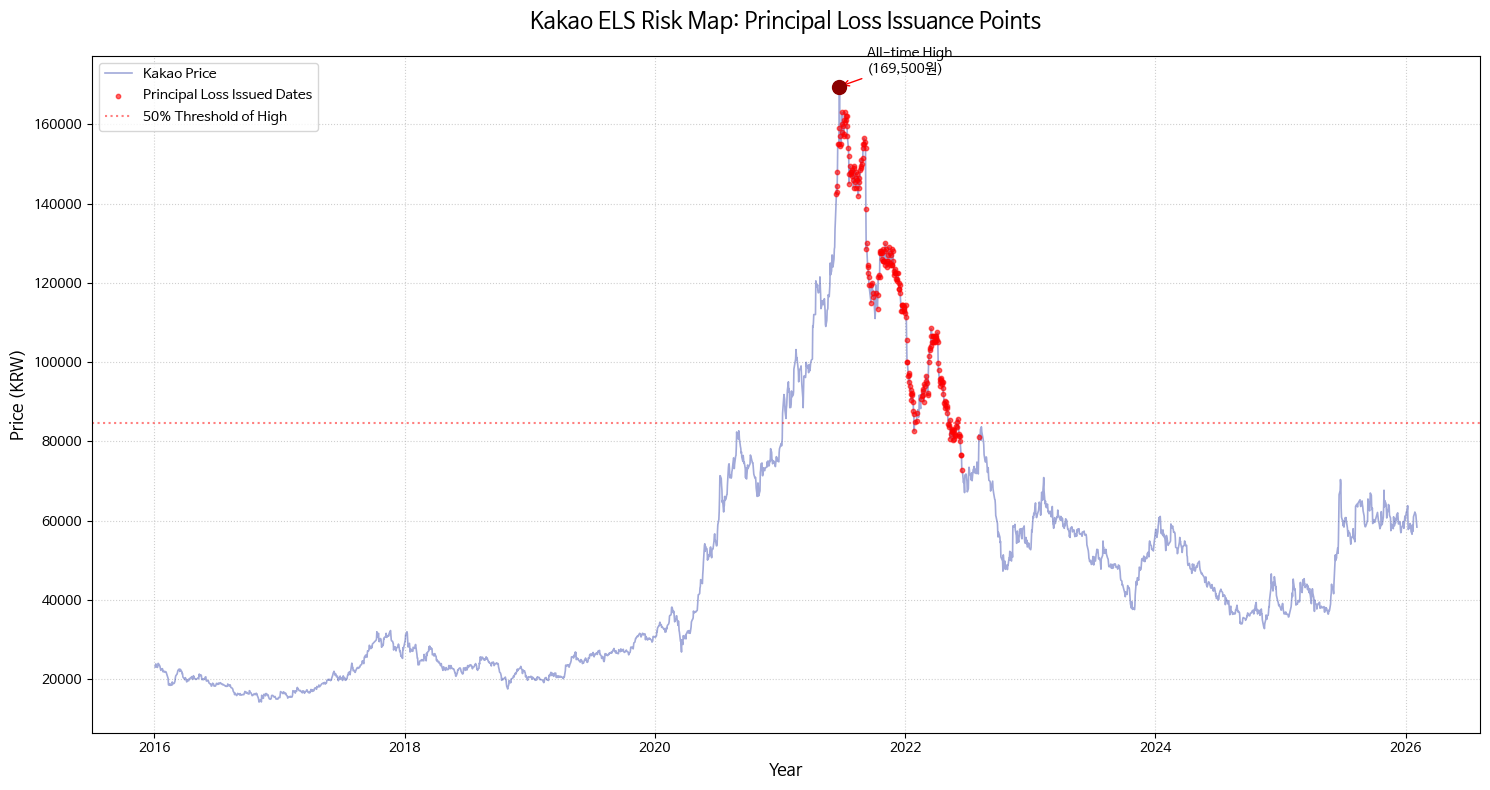

In [54]:
# 원금 손실 구간 시각화

import matplotlib.pyplot as plt

# 1. 원금 손실이 발생한 행들만 추출
loss_df = res_df_kakao[res_df_kakao['구분'] == "원금손실"].copy()

# 2. 그래프 그리기 (삼성전자 스타일 유지)
plt.figure(figsize=(15, 8))

# [A] 기본 주가 선 (파란색)
plt.plot(df2_kakao.index, df2_kakao['Close'], label='Kakao Price', color='#1428a0', linewidth=1.2, alpha=0.4)

# [B] 원금 손실 발생 지점 (발행일 기준 빨간색 점)
# 발행일에 해당하는 종가를 가져와서 점을 찍습니다.
loss_dates = loss_df['발행일']
loss_prices = df2_kakao.loc[loss_dates, 'Close']

plt.scatter(loss_dates, loss_prices, color='red', s=10, label='Principal Loss Issued Dates', alpha=0.6, zorder=5)

# 3. 주요 지표 및 이벤트 표시 (삼성전자와 동일 스타일)
# 최고점 표시
max_val_k = df2_kakao['Close'].max()
max_date_k = df2_kakao['Close'].idxmax()
plt.scatter(max_date_k, max_val_k, color='darkred', s=100, zorder=6)
plt.annotate(f'All-time High\n({max_val_k:,.0f}원)',
             xy=(max_date_k, max_val_k), xytext=(20, 10),
             textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

# 4. 낙인 배리어(50%) 안내선 (예시로 최고점 기준 50% 선 하나 그려줌)
# 실제로는 발행일마다 다르지만, 시각적 이해를 돕기 위해 최고점의 50% 지점을 점선으로 표시
plt.axhline(max_val_k * 0.5, color='red', linestyle=':', alpha=0.5, label='50% Threshold of High')

# 5. 그래프 꾸미기
plt.title('Kakao ELS Risk Map: Principal Loss Issuance Points', fontsize=16, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (KRW)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()